# Hidden Markov Model
Not a great attempt

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset

nc_file = '../cloud_results.nc'

# Show all variables
with Dataset(nc_file, 'r') as dataset:
    for var in dataset.variables:
        print(f"shape of {var}: {dataset.variables[var].shape}")

shape of age: (10000, 40)
shape of circum_per_level: (10000, 40, 160)
shape of cloud_base_area: (10000, 40)
shape of eff_radius_per_level: (10000, 40, 160)
shape of height: (160,)
shape of location_x: (10000, 40)
shape of location_y: (10000, 40)
shape of location_z: (10000, 40)
shape of mass_flux: (10000, 40)
shape of mass_flux_per_level: (10000, 40, 160)
shape of max_height: (10000, 40)
shape of max_w: (10000, 40)
shape of max_w_cloud_base: (10000, 40)
shape of ql_flux: (10000, 40)
shape of size: (10000, 40)
shape of surface_area: (10000, 40)
shape of temp_per_level: (10000, 40, 160)
shape of theta_outside_per_level: (10000, 40, 160)
shape of valid_track: (10000,)
shape of w_per_level: (10000, 40, 160)


Loading cloud data...
Total tracks: 10000, Valid tracks: 9500
Found 160 clouds with complete lifecycles and valid data
Training 2-state HMM...
  Log-likelihood: -1184.58, BIC: 2691.36
Training 3-state HMM...
  Log-likelihood: 5.38, BIC: 501.82
Training 4-state HMM...
  Log-likelihood: 1537.93, BIC: -2358.25
Training 5-state HMM...
  Log-likelihood: 1806.12, BIC: -2674.95


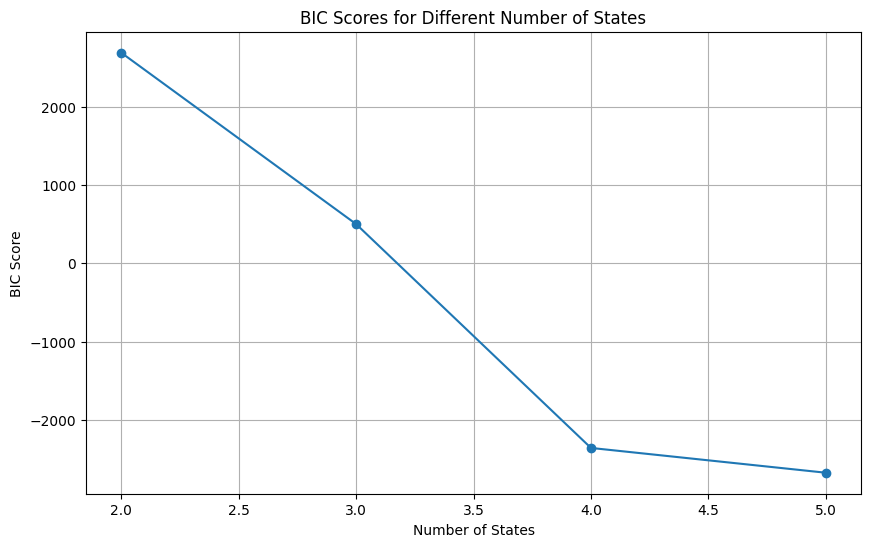


Best model has 5 states based on BIC


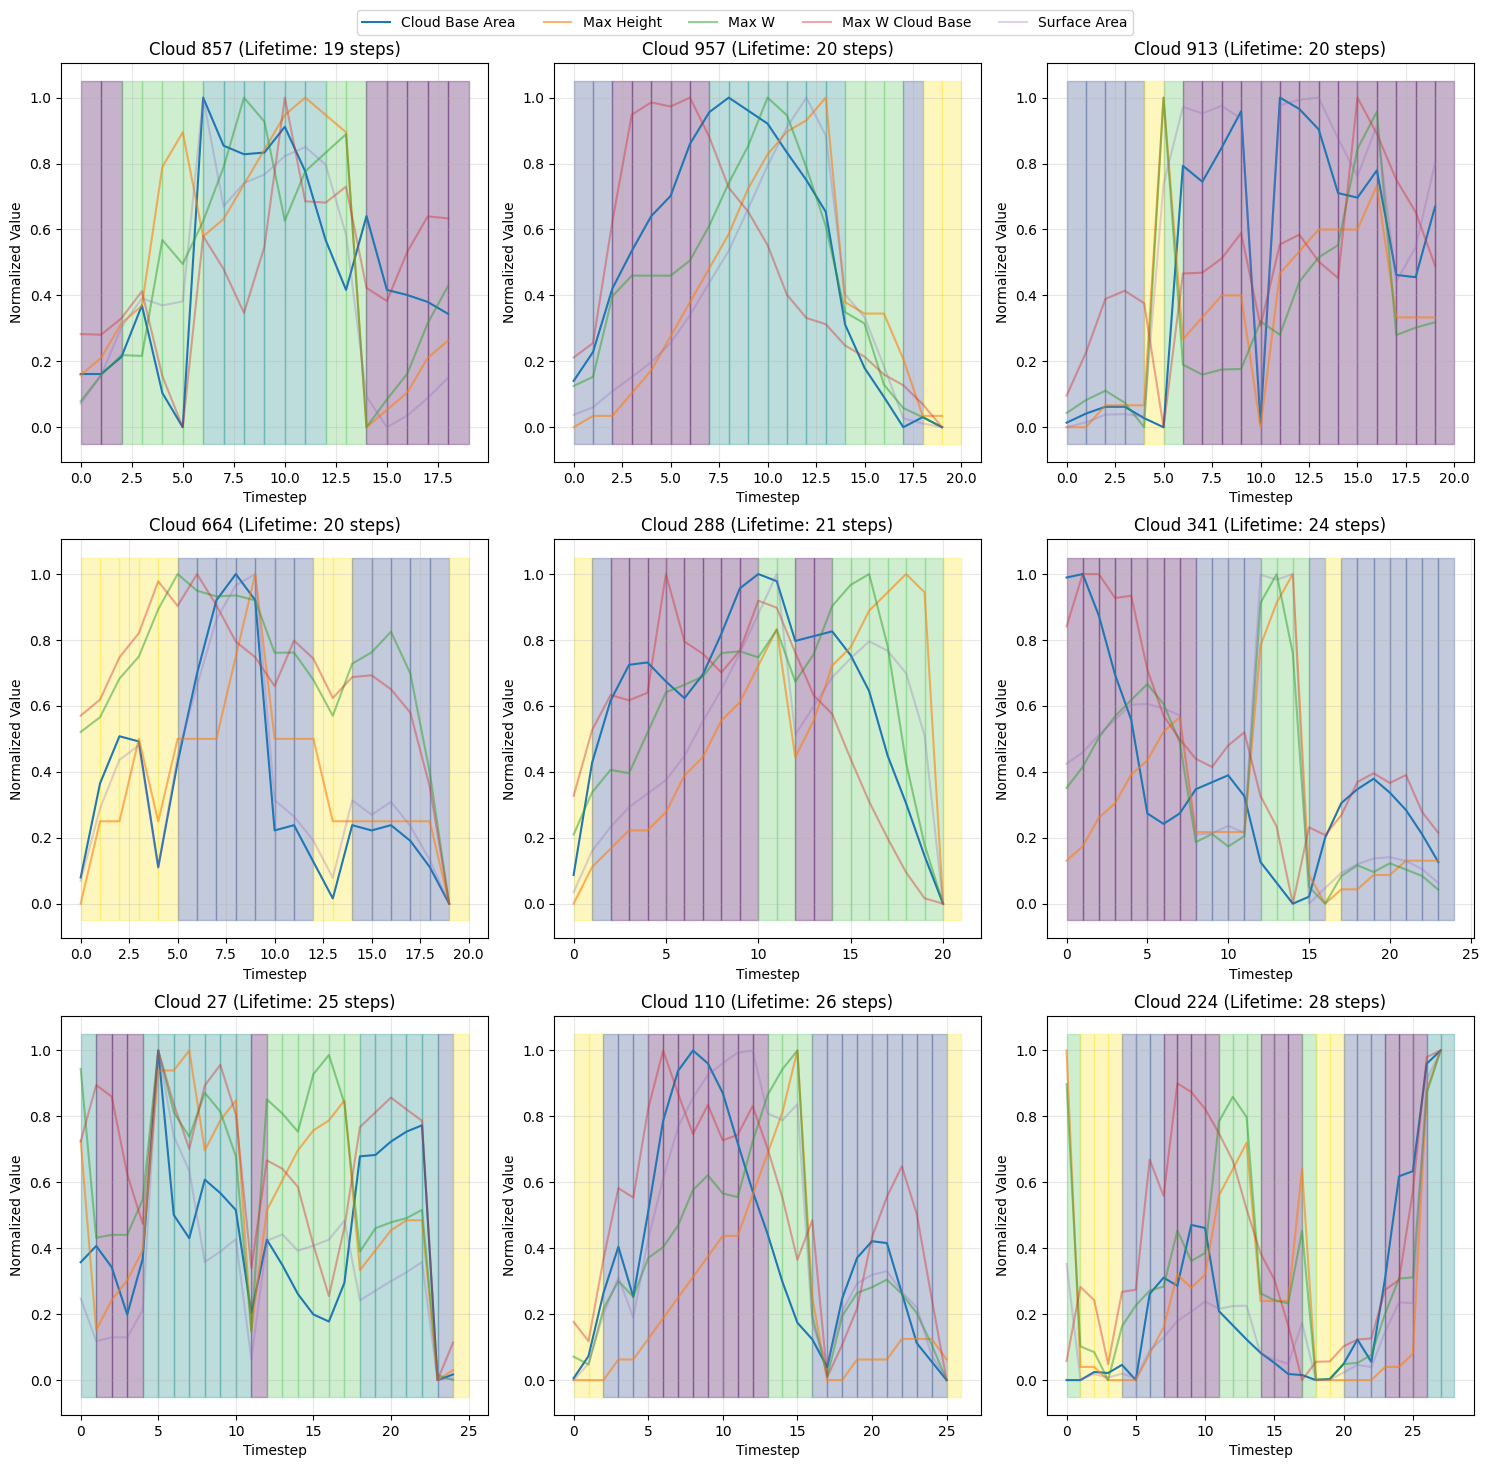

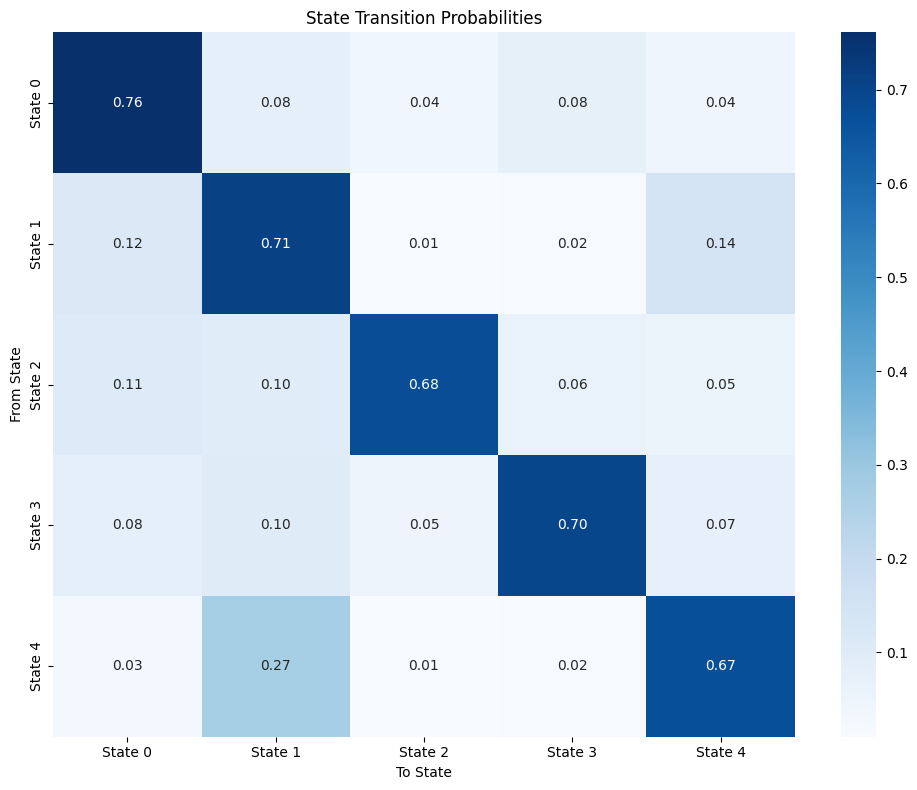

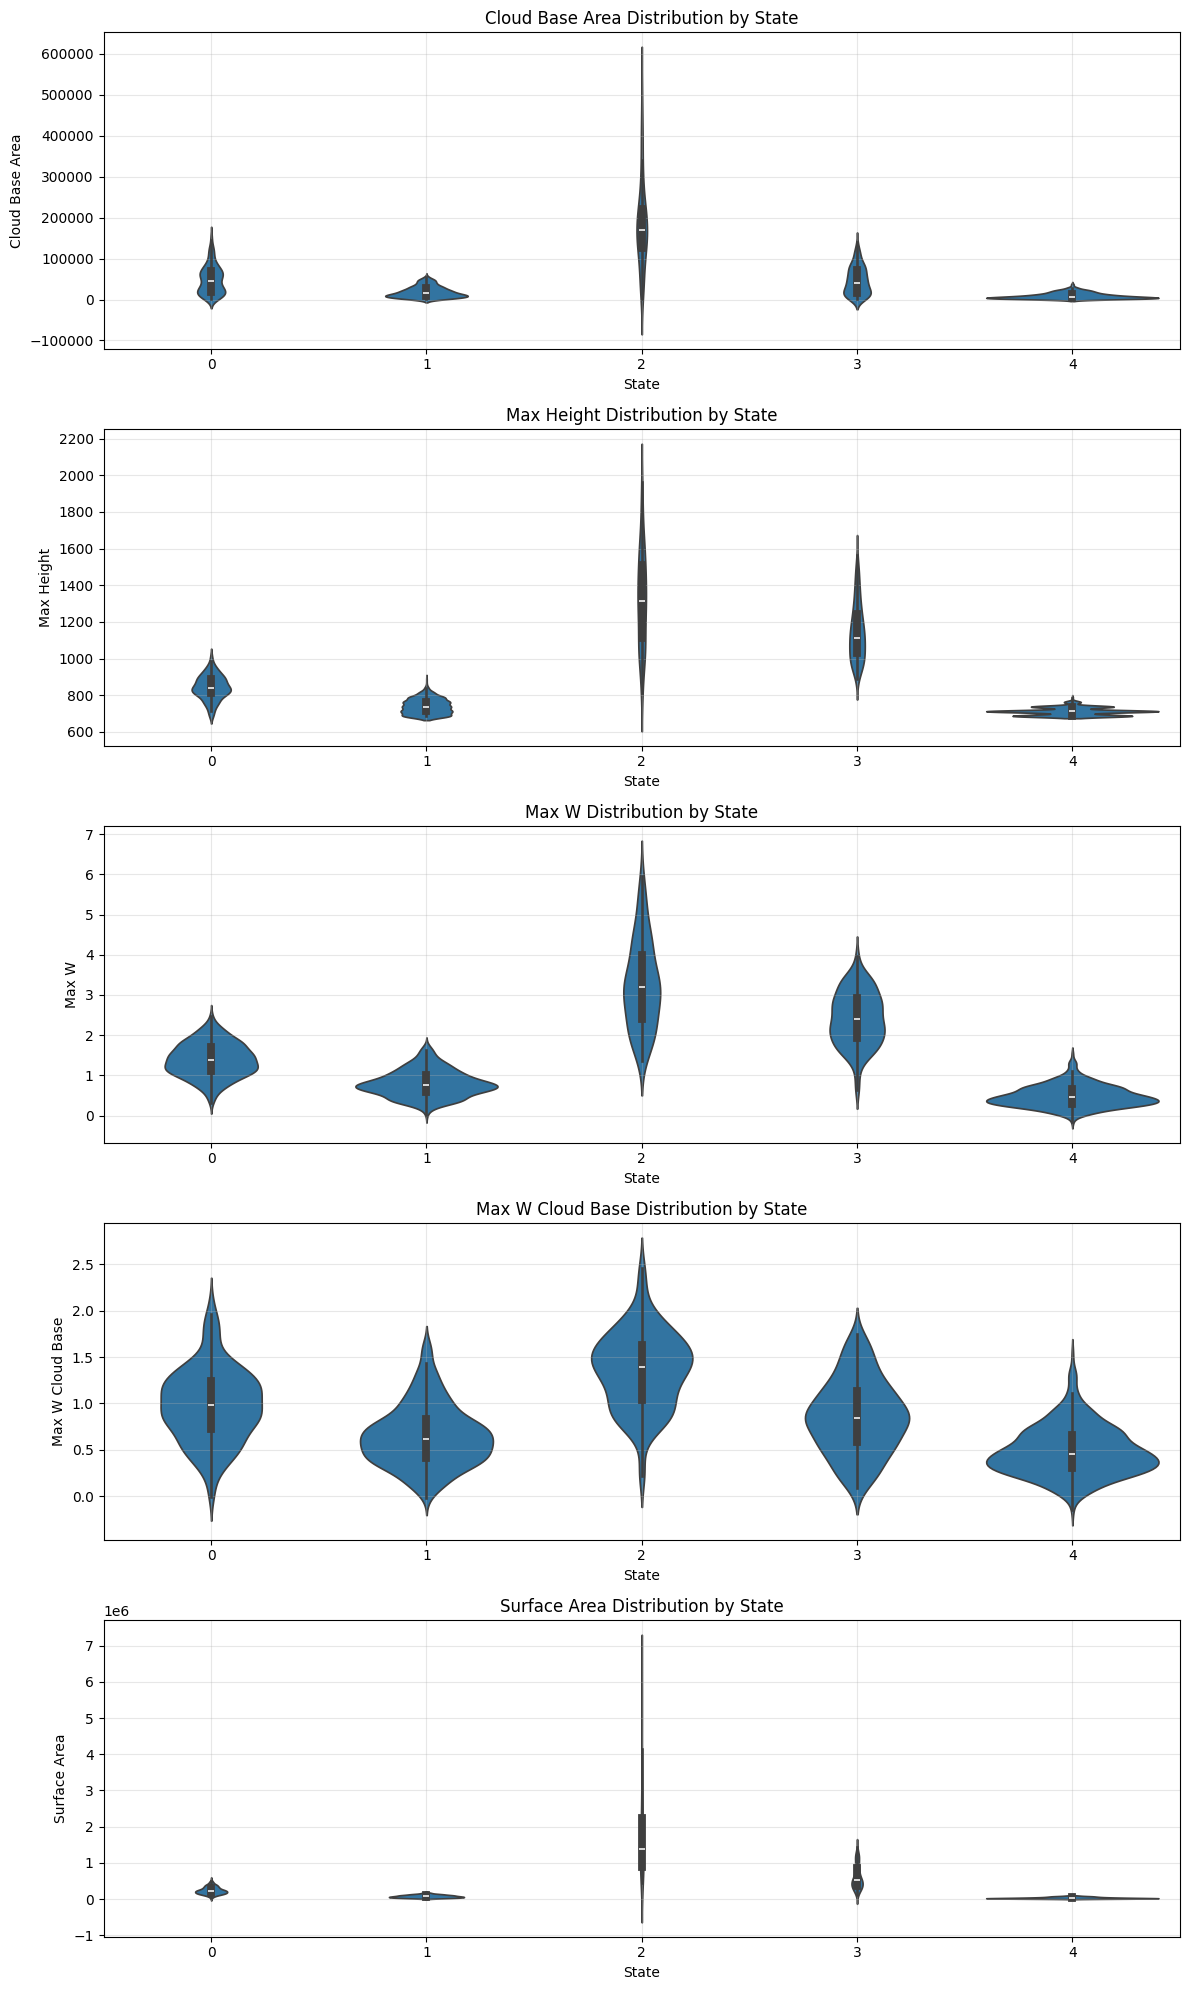


Feature Means by State:
       Cloud Base Area   Max Height     Max W  Max W Cloud Base  Surface Area
State                                                                        
0         49557.691406   843.115356  1.388266          0.984541  2.383173e+05
1         18836.484375   741.328430  0.801454          0.653018  7.710793e+04
2        186534.656250  1325.866333  3.251194          1.360717  1.831671e+06
3         46976.746094  1147.383667  2.415076          0.854815  6.163881e+05
4          9476.938477   712.500000  0.487481          0.487363  3.514038e+04

Suggested State Interpretations:
State 0: Transitional
State 1: Transitional
State 2: Mature / Active
State 3: Transitional
State 4: Early Formation / Small


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from netCDF4 import Dataset
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import seaborn as sns
from scipy import stats

def load_cloud_data(nc_file, min_lifetime=3):
    """Load cloud tracking data from NetCDF file."""
    with Dataset(nc_file, 'r') as dataset:
        # Get valid tracks (complete lifecycles only)
        valid_tracks = dataset.variables['valid_track'][:] == 1
        print(f"Total tracks: {len(valid_tracks)}, Valid tracks: {np.sum(valid_tracks)}")
        
        # Extract key variables
        max_height = dataset.variables['max_height'][:][valid_tracks, :]
        max_w = dataset.variables['max_w'][:][valid_tracks, :]
        cloud_base_area = dataset.variables['cloud_base_area'][:][valid_tracks, :]
        max_w_cloud_base = dataset.variables['max_w_cloud_base'][:][valid_tracks, :]
        surface_area = dataset.variables['surface_area'][:][valid_tracks, :]
        
        # Filter clouds with minimum lifetime
        cloud_data = []
        cloud_ids = []
        cloud_lifetimes = []
        
        for i in range(cloud_base_area.shape[0]):
            # Check for timesteps where ALL features are valid (not NaN)
            valid_steps = (~np.isnan(cloud_base_area[i, :]) & 
                           ~np.isnan(max_height[i, :]) & 
                           ~np.isnan(max_w[i, :]) &
                           ~np.isnan(max_w_cloud_base[i, :]) & 
                           ~np.isnan(surface_area[i, :]))
            
            cloud_lifetime = np.sum(valid_steps)
            
            if cloud_lifetime >= min_lifetime:
                # Extract features only for valid timesteps
                features = []
                valid_timesteps = np.where(valid_steps)[0]
                
                for t in valid_timesteps:
                    feature_vec = [
                        cloud_base_area[i, t],
                        max_height[i, t],
                        max_w[i, t],
                        max_w_cloud_base[i, t],
                        surface_area[i, t]
                    ]
                    features.append(feature_vec)
                
                # Only include if we have enough timesteps
                if len(features) >= min_lifetime:
                    features_array = np.array(features)
                    # Final NaN check
                    if not np.isnan(features_array).any():
                        cloud_data.append(features_array)
                        cloud_ids.append(i)
                        cloud_lifetimes.append(cloud_lifetime)
        
        print(f"Found {len(cloud_data)} clouds with complete lifecycles and valid data")
    
    return cloud_data, cloud_ids, cloud_lifetimes

def fit_hmm_models(cloud_data, n_states_range=range(2, 6)):
    """Fit HMM models with different numbers of states."""
    
    if not cloud_data:
        raise ValueError("No valid cloud data available for HMM fitting")
    
    # Combine all cloud data for scaling
    all_features = np.vstack([cloud for cloud in cloud_data])
    
    # Double check for NaN values
    if np.isnan(all_features).any():
        print("Warning: NaN values found! Filtering affected data...")
        valid_rows = ~np.isnan(all_features).any(axis=1)
        all_features = all_features[valid_rows]
        
        if all_features.shape[0] == 0:
            raise ValueError("No valid data remains after filtering NaNs")
    
    # Scale features
    scaler = StandardScaler()
    all_features_scaled = scaler.fit_transform(all_features)
    
    # Split back into individual cloud sequences
    start_idx = 0
    scaled_cloud_data = []
    for cloud in cloud_data:
        end_idx = start_idx + cloud.shape[0]
        # Scale each cloud directly
        scaled_cloud = scaler.transform(cloud)
        scaled_cloud_data.append(scaled_cloud)
        start_idx = end_idx
    
    # Fit HMMs with different numbers of states
    models = {}
    bic_scores = {}
    
    for n_states in n_states_range:
        print(f"Training {n_states}-state HMM...")
        
        # Initialize HMM
        model = hmm.GaussianHMM(
            n_components=n_states,
            covariance_type="full",
            n_iter=100,
            random_state=42,
        )
        
        try:
            # Fit model
            lengths = [len(cloud) for cloud in scaled_cloud_data]
            X = np.vstack(scaled_cloud_data)
            
            model.fit(X, lengths=lengths)
            
            # Calculate BIC score
            loglik = model.score(X, lengths=lengths)
            n_features = X.shape[1]
            n_params = (n_states * n_states - 1)  # Transition matrix
            n_params += n_states - 1  # Starting probabilities
            n_params += n_states * n_features  # Means
            n_params += n_states * n_features * (n_features + 1) // 2  # Covariances
            bic = -2 * loglik + np.log(X.shape[0]) * n_params
            
            models[n_states] = model
            bic_scores[n_states] = bic
            
            print(f"  Log-likelihood: {loglik:.2f}, BIC: {bic:.2f}")
        except Exception as e:
            print(f"  Error fitting {n_states}-state model: {str(e)}")
    
    if not models:
        raise ValueError("No models could be successfully fitted")
    
    return models, bic_scores, scaler

def classify_cloud_stages(cloud_data, model, scaler):
    """Classify development stages using trained HMM."""
    
    cloud_states = []
    cloud_probs = []
    
    for cloud in cloud_data:
        # Scale features
        cloud_scaled = scaler.transform(cloud)
        
        # Predict states
        states = model.predict(cloud_scaled)
        
        # Calculate state probabilities
        probs = model.predict_proba(cloud_scaled)
        
        cloud_states.append(states)
        cloud_probs.append(probs)
    
    return cloud_states, cloud_probs

def visualize_cloud_lifecycle(cloud_data, cloud_states, cloud_ids, lifetimes, feature_names):
    """Visualize cloud lifecycle with assigned states."""
    # Choose 9 clouds with the longest lifetimes for visualization
    cloud_indices = np.argsort(lifetimes)[-9:]
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    n_states = len(np.unique(np.concatenate(cloud_states)))
    colors = plt.cm.viridis(np.linspace(0, 1, n_states))
    
    for i, idx in enumerate(cloud_indices):
        if i >= len(axes):
            break
            
        ax = axes[i]
        cloud = cloud_data[idx]
        states = cloud_states[idx]
        cloud_id = cloud_ids[idx]
        
        # Plot each feature
        for j, feature_name in enumerate(feature_names):
            # Normalize feature values for better visualization
            feature_values = cloud[:, j]
            normalized = (feature_values - np.min(feature_values)) / (np.max(feature_values) - np.min(feature_values) + 1e-10)
            
            # Plot with transparency based on feature index
            alpha = 1.0 if j == 0 else 0.7 - 0.1*j  # Make size most visible
            ax.plot(normalized, alpha=alpha, label=feature_name if i == 0 else "")
        
        # Add colored background for states
        ylim = ax.get_ylim()
        for t in range(len(states)):
            ax.fill_between([t, t+1], ylim[0], ylim[1], 
                            color=colors[states[t]], 
                            alpha=0.3)
        
        ax.set_title(f"Cloud {cloud_id} (Lifetime: {lifetimes[idx]} steps)")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Normalized Value")
        ax.grid(True, alpha=0.3)
    
    # Add a single legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=5)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.savefig("cloud_lifecycle_states.png", dpi=300, bbox_inches='tight')
    plt.show()

def visualize_state_transitions(cloud_states, n_states):
    """Visualize state transitions as a heat map."""
    # Count transitions
    transitions = np.zeros((n_states, n_states))
    
    for states in cloud_states:
        for t in range(len(states) - 1):
            from_state = states[t]
            to_state = states[t + 1]
            transitions[from_state, to_state] += 1
    
    # Convert to probabilities
    for i in range(n_states):
        row_sum = np.sum(transitions[i, :])
        if row_sum > 0:
            transitions[i, :] /= row_sum
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(transitions, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=[f"State {i}" for i in range(n_states)],
                yticklabels=[f"State {i}" for i in range(n_states)])
    plt.title("State Transition Probabilities")
    plt.xlabel("To State")
    plt.ylabel("From State")
    plt.tight_layout()
    plt.savefig("state_transitions.png", dpi=300, bbox_inches='tight')
    plt.show()

def interpret_states(cloud_data, cloud_states, scaler, feature_names):
    """Analyze feature distributions for each state."""
    # Combine all cloud data and states
    all_features = np.vstack([cloud for cloud in cloud_data])
    all_states = np.concatenate(cloud_states)
    
    # Create dataframe
    df = pd.DataFrame(all_features, columns=feature_names)
    df['State'] = all_states
    
    # Plot feature distributions by state
    n_states = len(np.unique(all_states))
    n_features = len(feature_names)
    
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
    
    for i, feature in enumerate(feature_names):
        ax = axes[i]
        sns.violinplot(x='State', y=feature, data=df, ax=ax)
        ax.set_title(f"{feature} Distribution by State")
        ax.set_xlabel("State")
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("state_feature_distributions.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a summary table of means for each feature by state
    state_means = df.groupby('State').mean()
    print("\nFeature Means by State:")
    print(state_means)
    
    # Suggest interpretations
    print("\nSuggested State Interpretations:")
    for state in range(n_states):
        state_data = state_means.loc[state]
        
        # Simple heuristic interpretation based on relative values
        # Replaced size with cloud base area
        base_area_percentile = stats.percentileofscore(state_means['Cloud Base Area'], state_data['Cloud Base Area'])
        height_percentile = stats.percentileofscore(state_means['Max Height'], state_data['Max Height'])
        w_percentile = stats.percentileofscore(state_means['Max W'], state_data['Max W'])
        # Added max_w at cloud base
        w_base_percentile = stats.percentileofscore(state_means['Max W Cloud Base'], state_data['Max W Cloud Base'])
        
        if base_area_percentile < 33 and height_percentile < 50:
            interpretation = "Early Formation / Small"
        elif base_area_percentile > 67 and height_percentile > 67 and w_percentile > 67:
            interpretation = "Mature / Active"
        elif base_area_percentile > 50 and height_percentile > 50 and w_percentile < 50:
            interpretation = "Late / Decaying"
        elif w_base_percentile > 67 and base_area_percentile < 67:
            interpretation = "Growing / Developing"
        else:
            interpretation = "Transitional"
            
        print(f"State {state}: {interpretation}")

def main():
    nc_file = '../cloud_results.nc'  # Update with actual path
    min_lifetime = 5  # Minimum cloud lifetime to consider
    
    # Define feature names - updated with new features
    feature_names = ["Cloud Base Area", "Max Height", "Max W", "Max W Cloud Base", "Surface Area"]
    
    # Load data
    print("Loading cloud data...")
    cloud_data, cloud_ids, lifetimes = load_cloud_data(nc_file, min_lifetime)
    
    # Test different numbers of states
    n_states_range = range(2, 6)  # Try 2-5 states
    
    # Fit models
    models, bic_scores, scaler = fit_hmm_models(cloud_data, n_states_range)
    
    # Plot BIC scores
    plt.figure(figsize=(10, 6))
    plt.plot(list(bic_scores.keys()), list(bic_scores.values()), 'o-')
    plt.xlabel("Number of States")
    plt.ylabel("BIC Score")
    plt.title("BIC Scores for Different Number of States")
    plt.grid(True)
    plt.savefig("bic_scores.png", dpi=300)
    plt.show()
    
    # Find best model based on BIC
    best_n_states = min(bic_scores, key=bic_scores.get)
    print(f"\nBest model has {best_n_states} states based on BIC")
    best_model = models[best_n_states]
    
    # Classify cloud stages
    cloud_states, cloud_probs = classify_cloud_stages(cloud_data, best_model, scaler)
    
    # Visualize cloud lifecycle with states
    visualize_cloud_lifecycle(cloud_data, cloud_states, cloud_ids, lifetimes, feature_names)
    
    # Visualize state transitions
    visualize_state_transitions(cloud_states, best_n_states)
    
    # Interpret states
    interpret_states(cloud_data, cloud_states, scaler, feature_names)

if __name__ == "__main__":
    main()